# [실습1] 도로주행 데이터를 활용한 Semantic Segmentation
---
이번 실습에서는 사전학습 U-Net 모델에 fine-tuning하여 Semantic Segmentation을 수행합니다.

## 라이브러리 import
Semantic segmentation 실습에 사용할 라이브러리들을 import 합니다.
* `torch, torchvision`: Pytorch 및 이미지 처리를 위한 표준 라이브러리입니다.
* `segmentation_models_pytorch`: 다양한 Segmentation을 위한 라이브러리입니다.
* `albumentations`: 이미지 증강 및 변환을 위한 라이브러리입니다.
* `sklearn.model_selection.KFold`: 데이터를 K개의 부분으로 나누어 교차 검증을 수행하는 데 사용됩니다.
* `pycocotools.mask`: COCO 데이터셋 형식의 마스크 처리를 위한 도구입니다.
* `matplotlib.pyplot, PIL.Image`: 이미지 세그멘테이션 결과를 시각적으로 확인하기 위해 사용됩니다.

In [1]:
!pip install -q segmentation_models_pytorch

In [ ]:
!pip install -q pycocotools

In [1]:
# import pytorch
import torch
from torch.optim import lr_scheduler

# import torchvision
import torchvision
from torchvision.transforms import functional as F

# import sementation models pytorch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils

# import albumentations
import albumentations as albu

# tools
from sklearn.model_selection import KFold
import pycocotools.mask as pycoco_mask
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import numpy as np
import hashlib
import random
import pickle
import json
import os
import datetime
import platform
import socket

/home/leelang/anaconda3/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## CONFIG 설정
딥 러닝 모델 학습을 위한 구성 설정을 담은 Python 딕셔너리를 생성합니다. 여기서 정의된 설정은 모델 학습 과정에서 사용됩니다.

In [2]:
CONFIG = {
    'random_seed': 1015, # 난수 시드
    'device': 'cuda', # 사용할 gpu 지정 => 'cpu'
    'img_size': {
                    'height': 1024, # 이미지 높이
                    'width': 1920   # 이미지 너비
                },

    'resize_to':{
                    'height': 512, # 이미지 높이
                    'width': 960   # 이미지 너비
                },
    'num_folds': 2,    # kfold에 사용될 폴드 수
    'num_epochs': 2,  # 학습 epoch 수
    'batch_size': 2,   # batch size
    'valid_batch_size' : 2,
    'num_workers': 2,
    'prefetch_factor' : 1, # 데이터 로딩 시 병렬 처리 설정
    'root': './',
    'models_path' : './models/semantic'
}

# 전처리한 데이터를 저장할 폴더 생성
os.system(f"mkdir -p ./semantic_preprocess_data")

0

## 난수 시드 고정
결과의 재현성을 보장하기 위해 다양한 난수 생성기에 대해 고정된 시드를 설정합니다. 이를 통해 모델 학습의 재현성을 보장합니다.

In [3]:
def seed_everything(seed):
    # 파이썬의 내장 난수 생성기 시드 고정
    random.seed(seed)
    # dictinary 항목의 순서 고정
    os.environ["PYTHONHASHSEED"] = str(seed)
    # NumPy 난수 시드 고정
    np.random.seed(seed)
    # PyTorch에서 난수 시드 고정
    torch.manual_seed(seed)
    # CUDA PyTorch 난수 시드 고정
    torch.cuda.manual_seed(seed)
    # PyTorch의 컨볼루션 신경망(CNN) 연산 고정
    torch.backends.cudnn.deterministic = True

seed_everything(CONFIG['random_seed'])

## 메타데이터 불러오기
`ss_label_id_list`라는 리스트에 Semantic segmentation 작업에 사용될 라벨과 해당 ID를 리스트 형태로 정의합니다. 각각의 라벨은 고유한 숫자 ID와 이름으로 구성됩니다.
* 본 실습의 Semantic segmentation에서는 배경(stuff)에 대한 segmentation만 수행합니다.

`parse_meta_data`는 주어진 경로(root)에서 메타 데이터를 파싱하여 추출하는 함수입니다.데이터가 저장되어있는 'batch_02_data' 디렉토리 내의 각 날짜별 디렉토리에서 'label_ps/FR-View-CMR-Wide' 경로(전면 카메라에 촬영된 이미지의 메타데이터)에 있는 메타 데이터 파일들을 읽어들여 처리합니다. JSON 형태의 메타데이터 파일을 읽고 파싱하여 `ps_meta_ls` 리스트에 추가하고 최종적으로 NumPy 배열로 변환하여 반환합니다.

`ps_meta_array`에는 `parse_meta_data`를 활용해 'CONFIG['root']' 경로에서 메타 데이터를 로드하여 배열로 저장합니다.

In [4]:
ps_meta_ls = []
ss_label_id_list = [(1 , "background" ), (2 , "unlabeled" ), (3 , "vegetation" ), (4 , "sky" ), (5 , "ego_vehicle" ),
                    (6 , "ground" ), (7 , "road" ), (8 , "rail_track" ), (9 , "sidewalk" ), (10 , "cycle_route" ),
                    (11 , "bridge" ), (12 , "fence" ), (13 , "garage" ), (14 , "guardrail" ), (15 , "tunnel" ),
                    (16 , "wall" ), (17 , "general_structure" ), (18 , "banner" ), (19 , "billboard" ), (20 , "road_edge" ),
                    (21 , "pole" ), (22 , "street_light" ), (23 , "removable_object" ), (24 , "traffic_light" ),
                    (25 , "traffic_sign" ), (26 , "line_white" ), (27 , "line_blue" ), (28 , "line_yellow" ), (29 , "rm_arrow" ),
                    (30 , "rm_character" ), (31 , "rm_number" ), (32 , "rm_figure" ), (33 , "guide_lane_blue" ),
                    (34 , "guide_lane_green" ), (35 , "guide_lane_red" ), (36 , "rm_cross" ), (37 , "stop_line" ),
                    (38 , "parking_strip" ), (39 , "speed_breaker" ), (40 , "curb" )]


def parse_meta_data(root):
    ps_meta_ls = []
    date_dirs = os.listdir(root + '/batch_02_data')
    for date_dir in tqdm(date_dirs):
        date_dir_path = f"{root}/batch_02_data/{date_dir}"
        #if date_dir == "mini_sample":
        #    continue

        # get panoptic meta data
        ps_meta_parrent_path = f"{date_dir_path}/label_ps/FR-View-CMR-Wide"
        print(ps_meta_parrent_path)
        ps_meta_file_ls = os.listdir(ps_meta_parrent_path)
        for ps_meta in ps_meta_file_ls:
            #if ps_meta == ".ipynb_checkpoints":
            #    continue
            ps_meta_path = f"{ps_meta_parrent_path}/{ps_meta}"
            f = open(ps_meta_path)
            ps_meta = json.load(f)
            ps_meta_ls.append(ps_meta)
    ps_meta_array = np.array(ps_meta_ls)
    return ps_meta_array

ps_meta_array = parse_meta_data(CONFIG['root'])

100%|██████████| 10/10 [00:00<00:00, 73.53it/s]

.//batch_02_data/2022-06-24_12-30-50_ADCV1-ADP1/label_ps/FR-View-CMR-Wide
.//batch_02_data/2022-07-26_09-39-42_ADCV1-ADP1/label_ps/FR-View-CMR-Wide
.//batch_02_data/2022-08-02_13-28-51_ADCV1-ADP1/label_ps/FR-View-CMR-Wide
.//batch_02_data/2022-08-05_15-49-08_ADCV1-ADP1/label_ps/FR-View-CMR-Wide
.//batch_02_data/2022-06-25_20-08-06_ADCV1-ADP1/label_ps/FR-View-CMR-Wide
.//batch_02_data/2022-08-25_16-32-20_ADCV1-ADP1/label_ps/FR-View-CMR-Wide
.//batch_02_data/2022-08-03_12-48-30_ADCV1-ADP1/label_ps/FR-View-CMR-Wide
.//batch_02_data/2022-07-21_17-39-55_ADCV1-ADP1/label_ps/FR-View-CMR-Wide
.//batch_02_data/2022-07-20_22-09-32_ADCV1-ADP1/label_ps/FR-View-CMR-Wide
.//batch_02_data/2022-06-24_14-25-57_ADCV1-ADP1/label_ps/FR-View-CMR-Wide


## 데이터 셋 정의
이미지 데이터를 읽고, 해당 이미지에 대한 semantic 레이블에 해당하는 마스크를 생성하여 학습에 사용할 수 있게 전처리하는 과정입니다.

`get_mask_index`: 주어진 라벨 ID에 대응하는 마스크 인덱스를 찾는 함수입니다. 각 세그멘테이션 라벨에 대한 인덱스를 얻기 위해 사용됩니다.

`parse_semantic_meta_data`: 메타 데이터에서 소스 이미지와 semantic 마스크를 파싱하는 함수입니다. 소스 이미지는 파일 경로에서 로드되며, semantic 마스크는 메타 데이터에 정의된 각 라벨에 따라 생성됩니다. `pycocotools.mask.decode`를 활용해 메타 데이터에 있는 인코딩된 마스크를 실제 이진 마스크로 변환합니다.

`to_tensor`: 이미지와 마스크를 PyTorch 텐서 형식으로 변환하는 함수입니다.

`SemanticSegmentationDataset`: Semantic Segmentation을 위한 데이터셋을 정의합니다.
* __init__: `ps_meta_ls`를 입력받아 데이터셋을 초기화하는 생성자입니다. `albumentation`라이브러리를 활용해 이미지와 마스크의 크기를 조정하고 재배열합니다.
* __len__: 데이터셋의 전체 길이(데이터 항목의 수)를 반환합니다.
* sha256_hash: 문자열을 입력받아 SHA-256 해시를 생성합니다. 이 메서드를 사용해 원본 이미지 경로를 인코딩하여 데이터의 키로 사용합니다.
* __getitem__: PyTorch 데이터셋 인터페이스의 일부로, 인덱스에 해당하는 데이터 항목을 반환합니다.

In [5]:
def get_mask_index(label_id_list, label_id):
    return np.where(np.array(label_id_list)[:,0] == str(label_id))[0][0]

def parse_semantic_meta_data(ps_meta):
    # get source image
    source_path = CONFIG['root'] + '/'+ ps_meta['parent_path'] +'/'+ ps_meta['filename']+'.png'
    img = Image.open(source_path)
    img = np.array(img)

    # get semantic masks
    semantic_masks = np.zeros([CONFIG['img_size']['height'], CONFIG['img_size']['width'], len(ss_label_id_list)]) # semantic segmentation의 label은 26개
    ps_meta['parent_path']
    for annotation in ps_meta['annotations']:
        if annotation['isthings'] == 1:
            continue
        mask = pycoco_mask.decode(annotation['points'])
        label_id = annotation["label_id"]
        mask_index = get_mask_index(ss_label_id_list, label_id)
        semantic_masks[:,:, mask_index] = pycoco_mask.decode(annotation['points'])
    return img, semantic_masks

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1) # h, w, c => c, h, w => b, c, h, w

class SemanticSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self,
                 ps_meta_ls = None,
                 preprocessing = None,
                 resize_to = CONFIG['resize_to'],
                 train = True
        ):
        self.ps_meta_ls = ps_meta_ls
        self.preprocessing = preprocessing
        self.resize_to = resize_to
        self.resize =  albu.Compose([
                                  albu.Resize(height = self.resize_to['height'],
                                              width = self.resize_to['width']),
                               ])
        self.to_tensor = albu.Compose([
                                  albu.Lambda(image = to_tensor, mask = to_tensor),
                               ])
        self.train = train

    def __len__(self):
        return len(self.ps_meta_ls)

    def sha256_hash(self, input_string):
        # SHA-256 해시 객체 생성
        hash_object = hashlib.sha256()
        # 입력 문자열을 바이트로 변환하고 해시 계산
        hash_object.update(input_string.encode())
        # 해시 값을 16진수 문자열로 변환
        hash_hex = hash_object.hexdigest()
        # 32바이트 길이로 자르기 (SHA-256은 기본적으로 32바이트 출력을 생성)
        return hash_hex[:32]


    def __getitem__(self,idx):
        ps_meta = self.ps_meta_ls[idx]
        source_path = CONFIG['root'] + '/' + ps_meta['parent_path'] +'/'+ ps_meta['filename']+'.png'

        # 원본이미지 경로를 sha256 인코딩하여 32개의 문자열 생성 -> 데이터의 키로 사용
        hashed_string = self.sha256_hash(source_path)

        # (전처리된 이미지, 타켓) 데이터를 {hashed_string}.pickle 이라는 이름으로 저장
        preprocess_data_path = f'./semantic_preprocess_data/{hashed_string}.pickle'
        if os.path.exists(preprocess_data_path):
            with open(preprocess_data_path, 'rb') as f:
                # 존재하면 저장된 값을 사용
                data = pickle.load(f)
                img, mask = data
            return img, mask

        img, semantic_masks = parse_semantic_meta_data(ps_meta)
        img = img / 255
        mask = semantic_masks
        if self.resize:
            sample = self.resize(image=img, mask=mask)
            img, mask = sample['image'], sample['mask']

        # reshape for converting to tensor (모두 적용)
        sample = self.to_tensor(image=img, mask=mask)
        img, mask = sample['image'], sample['mask']

        img = img.astype('float32')
        mask = mask.astype('uint8')


        with open(preprocess_data_path, 'wb') as handle:
            data = (img, mask)
            pickle.dump(data, handle)

        return img, mask

## 모델 학습
K-fold 교차검증을 설정하고 `SemanticSegmentationDataset` 데이터셋을 사용하여 훈련 및 검증 데이터셋을 생성합니다. 사전학습 되어 있는 U-Net 모델을 불러와 도로 주행 데이터셋을 fine-tuning하여 semantic segmentation 모델을 생성합니다. 손실 함수로는 다중 라벨 시맨틱 세그멘테이션에 적합한 DiceLoss을 사용하고 옵티마이저로는 Adam, 학습률은 0.0001로 설정합니다.

### [TODO] 사전학습모델 불러오기
인코더(축소경로)가 `efficientnet-b4`이고 `imagenet` 데이터를 학습한 **U-Net** 사전학습 모델을 정의합니다.

In [6]:
def unet_training():
    # KFold 생성
    kfold = KFold(
        n_splits=CONFIG['num_folds'],
        random_state=CONFIG['random_seed'],
        shuffle=True
    )

    # k-겹 교차 검증 수행
    for fold_idx, (train_ps_meta_array_idx, valid_ps_meta_array_idx) in enumerate(kfold.split(ps_meta_array)):
        train_fold = ps_meta_array[train_ps_meta_array_idx]
        valid_fold = ps_meta_array[valid_ps_meta_array_idx]

        # 데이터셋 생성
        train_dataset = SemanticSegmentationDataset(train_fold)
        valid_dataset = SemanticSegmentationDataset(valid_fold)

        # 데이터 로더 생성
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=CONFIG['batch_size'],
            shuffle=True
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset,
            batch_size=CONFIG['valid_batch_size'],
            shuffle=False
        )

        #######################################
        # [TODO] 사전학습모델 불러오기              #
        # 상단 지시사항에 따라 None을 지우고 코드 작성  #
        #######################################
        model = smp.Unet(
            encoder_name="efficientnet-b4",
            encoder_weights="imagenet",
            in_channels=3,
            classes=len(ss_label_id_list),
            activation='sigmoid'
        )

        # 손실 함수 설정
        loss = smp.losses.DiceLoss("multilabel", log_loss=True, from_logits=False)
        loss.__name__ = 'DiceLoss'

        # 옵티마이저 설정
        optimizer = torch.optim.Adam([
            dict(params=model.parameters(), lr=0.0001)
        ])

        # 메트릭 정의
        metrics = [
            smp_utils.metrics.IoU(threshold=0.5),
            smp_utils.metrics.Fscore(threshold=0.5)
        ]

        # 스케줄러 설정
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, 2, eta_min=1e-6)

        # 훈련 및 validation epoch 설정
        train_epoch = smp_utils.train.TrainEpoch(
            model,
            loss=loss,
            metrics=metrics,
            optimizer=optimizer,
            device=CONFIG['device'],
            verbose=True
        )
        valid_epoch = smp.utils.train.ValidEpoch(
            model,
            loss=loss,
            metrics=metrics,
            device=CONFIG['device'],
            verbose=True
        )

        # 훈련 및 검증 로그
        train_logs_ls = []
        valid_logs_ls = []

        # training loop
        for epoch in range(CONFIG['num_epochs']):
            print('\nEpoch: {}'.format(epoch))
            train_logs = train_epoch.run(train_loader)
            valid_logs = valid_epoch.run(valid_loader)
            scheduler.step()
            train_logs_ls.append(train_logs)
            valid_logs_ls.append(valid_logs)

        #break # 첫 번째 폴드 후에 중지하려면 이 주석을 해제

    return model

model = unet_training()


Epoch: 0
valid: 100%|██████████| 125/125 [00:09<00:00, 13.35it/s, DiceLoss - 1.784, iou_score - 0.03341, fscore - 0.06434]

Epoch: 1
valid: 100%|██████████| 125/125 [00:08<00:00, 14.34it/s, DiceLoss - 1.596, iou_score - 0.05489, fscore - 0.1038]

Epoch: 0
valid: 100%|██████████| 125/125 [00:08<00:00, 14.21it/s, DiceLoss - 1.802, iou_score - 0.04067, fscore - 0.07786]

Epoch: 1
valid: 100%|██████████| 125/125 [00:08<00:00, 14.94it/s, DiceLoss - 1.6, iou_score - 0.05666, fscore - 0.1068]  


## 모델 예측 시각화
모델의 semantic segmentation 결과를 시각화 하는 코드입니다. 딕셔너리 `color_map`에는 각 클래스별 세그멘테이션 마스크 색상이 16진수로 매핑되어있습니다.

In [8]:
# id에 따른 세그멘테이션 마스크 색상 설정
color_map = {
    1:  "FFFFFF"   ,
    2:  "783C82"   ,
    3:  "3C5A3C"   ,
    4:  "4696DC"   ,
    5:  "46D2C8"   ,
    6:  "6428C8"   ,
    7:  "8264B4"   ,
    8:  "E6968C"   ,
    9:  "DC1EE6"   ,
    10:  "C85A5A"   ,
    11:  "966464"   ,
    12:  "00BE00"   ,
    13:  "E6D2FA"   ,
    14:  "B4A0B4"   ,
    15:  "96785A"   ,
    16:  "6400B4"   ,
    17:  "F0A0AA"   ,
    18:  "A0F0FA"   ,
    19:  "B4FA3C"   ,
    20:  "96BE28"   ,
    21:  "FAFA8C"   ,
    22:  "A0FAC8"   ,
    23:  "FA0082"   ,
    24:  "1E3C96"   ,
    25:  "1EDCDC"   ,
    26:  "C81EC8"   ,
    27:  "00008C"  ,
    28:  "DCDC00"  ,
    29:  "BE9696"  ,
    30:  "969696"  ,
    31:  "FAAA1E"  ,
    32:  "6464A0"  ,
    33:  "00B4F0"  ,
    34:  "96FA96"  ,
    35:  "FAC8FA"  ,
    36:  "D2326E"  ,
    37:  "00B464"  ,
    38:  "0000E6"  ,
    39:  "825000"  ,
    40:  "787800"  ,
    41:  "699B2D",
    42:  "9B4B4B",
    42:  "7D1969",
    43:  "696941",
    44:  "0FB90F",
    45:  "0F4B19",
    46:  "D79B23",
    47:  "730F23",
    48:  "054169",
    49:  "05E1E1",
    50:  "0569CD",
    51:  "056969",
    52:  "05054B",
    53:  "7D5523",
    54:  "7D370F",
    55:  "7D1937",
    56:  "9B3723",
    57:  "B9234B",
    58:  "B90F9B",
    59:  "553723",
    60:  "373723",
    61:  "555523",
    62:  "553769",
    63:  "7D3737",
    64:  "9B7373",
    65:  "FFFF00",
}

16진수 마스크 색상 딕셔너리를 활용해 세그멘테이션 결과를 시각화합니다.
* `hex_sum_to_rgb`: 입력받은 16진수 색상 코드를 RGB 값으로 변환합니다. 16진수 코드를 정수로 변환한 뒤, 이를 RGB 채널 의 0~255 값으로 분해합니다.
* `get_label_image`은 encodeing된 label과 같이 입력된 색상코드를 활용하여 라벨 이미지를 생성합니다.
* `show_overray_img`은 segmentation mask와 원본 이미지를 겹쳐서 segmentation 결과를 확인할 수 있도록 하는 함수입니다.

In [9]:
def hex_sum_to_rgb(hex_sum):
    try:
        decimal_sum = int(hex_sum, 16)
    except ValueError:
        raise ValueError("Invalid hexadecimal sum.")

    if decimal_sum < 0:
        raise ValueError("Sum value must be non-negative.")

    red = decimal_sum % 256
    green = (decimal_sum // 256) % 256
    blue = (decimal_sum // (256 * 256)) % 256

    return red, green, blue

def get_label_image(label_map, hex_color, alpha):
    label_map = label_map[np.newaxis, :]

    r,g,b = hex_sum_to_rgb(hex_color)
    label_image = np.concatenate(
        [label_map * r / 255,
        label_map * g / 255,
        label_map * b / 255,
        (label_map == 1) * alpha],
    axis = 0).transpose(1,2,0)
    return label_image

def show_overray_img(mask_array, img, title, alpha = 0.5):
    plt.imshow(img) # segment map만을 확인하려면 이 부분을 주석처리
    for i in range(mask_array.shape[2]):
        hex_color = color_map[i+1]
        plt.imshow(get_label_image(mask_array[:,:,i], hex_color, alpha = alpha))
    plt.title(title)
    plt.show()

샘플 이미지를 하나 골라서 segmentation 결과를 확인해보겠습니다. `sample_idx`의 인덱스에 해당하는 이미지와 마스크를 가져와 시각화합니다. `SemanticSegmentationDataset` 클래스를 활용해 `ps_meta_array`를 기반으로 데이터셋 객체를 생성하고 데이터셋에서 `sample_idx`번째 샘플을 로드합니다.

해당 샘플 데이터에서 이미지 부분을 가져와 (높이, 너비, RGB) 형식으로 변환하여 `sample_image`에 저장하고 .이미지 데이터를 넘파이 배열에서 PyTorch 텐서로 변환하여 모델에 학습시킬 수 있도록 지정된 device로 이동시킵니다.

### [TODO] Semantic Segmentation을 위한 샘플 데이터셋 생성
이미지 및 관련 레이블에 대한 메타데이터 정보를 담고 있는 리스트 `ps_meta_array`를 활용하여 샘플 데이터셋을 생성하세요.

In [10]:
data_size = len(ps_meta_array)

# 샘플 선택
sample_idx = 40

# [TODO] Semantic Segmentation을 위한 샘플 데이터셋 생성
# 앞서 구현한 SemanticSegmentationDataset을 활용
sample_dataset = SemanticSegmentationDataset(ps_meta_array)

sample = sample_dataset[sample_idx]

sample_image = sample[0].transpose(1,2,0)

x = torch.from_numpy(sample[0][np.newaxis, ...]).to(CONFIG["device"])

## 모델 시각화
학습을 수행한 모델의 결과를 시각화합니다. 모델을 평가(evaluation) 모드로 설정하여 드롭아웃 등의 설정을 비활성화하고 텐서로 변환된 샘플 데이터를 모델에 전달합니다. 예측된 마스크와 레이블을 CPU로 가져와 numpy 배열로 변환하고 각 픽셀에 대해 가장 높은 확률 값을 가진 라벨을 선택합니다. 이후 `show_overray_img` 함수를 사용하여, Ground Truth(실제 라벨)와 모델의 예측 결과를 원본 이미지 위에 오버레이하여 시각화합니다.

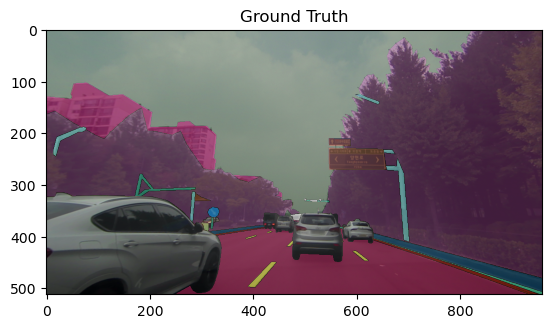

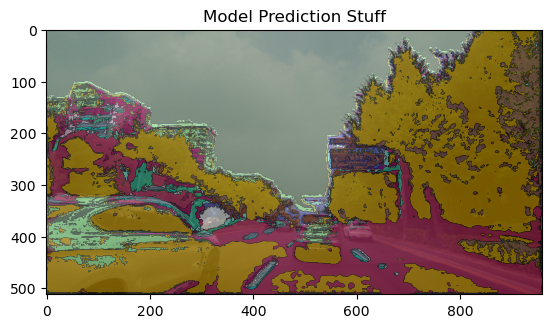

In [12]:
model.eval()
pred = model.forward(x)

pred = pred.detach().cpu().numpy()[0]

pred_max = pred.max(axis = 0)
pred = (pred >= pred_max)

show_overray_img(sample[1].transpose(1,2,0), sample_image, "Ground Truth")
show_overray_img(pred.transpose(1,2,0)[:,:,:], sample_image, "Model Prediction Stuff")

학습시킨 모델을 저장해두었다가 불러와서 사용할 수도 있습니다. 추후 Panoptic segmentation에서 활용할 수 있도록 학습시킨 모델을 `custom_ss_model.pth`파일로 저장합니다.

In [13]:
torch.save(model, "custom_ss_model.pth")

모델의 epoch 값을 늘려주어 학습을 반복해서 수행하면 아래와 같은 결과를 얻을 수 있습니다. epoch값을 변경해 최선의 semantic segmentation 모델을 생성해보세요.

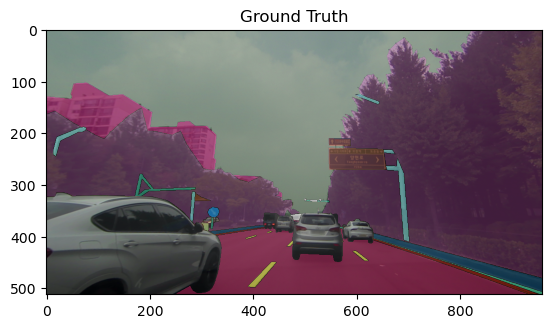

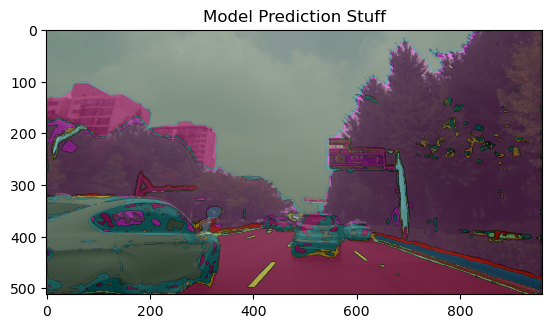

In [14]:
best_model = torch.load(f"best_semantic_segmentation_model.pth", weights_only=False)
best_model.eval()
bm_pred = best_model.forward(x)

bm_pred = bm_pred.detach().cpu().numpy()[0]

bm_pred_max = bm_pred.max(axis = 0)
bm_pred = (bm_pred >= bm_pred_max)

show_overray_img(sample[1].transpose(1,2,0), sample_image, "Ground Truth")
show_overray_img(bm_pred.transpose(1,2,0)[:,:,:], sample_image, "Model Prediction Stuff")

### [TODO] 최선의 모델 생성하기
코드의 맨 위로 올라가 `CONFIG`에서 **num_epochs', 'batch_size'** 등을 수정한 뒤 다시 모델을 학습시킵니다. 최선의 모델을 찾아 `model`에 저장하세요. 최종 `model`의 mIoU값이 0.2 이상이어야 합니다.

---

# 채점
채점을 위한 코드입니다. 아래 코드를 실행하시고 우측 상단의 제출 버튼을 누르면 채점이 진행됩니다.
* **채점을 위해선 97번 이미지에 대한 예측 결과가 제출되어야 합니다. 올바른 채점을 위해 `sample_idx`를 26으로 설정하고 코드를 실행한 뒤 제출하세요**
* 위의 실습 지시사항을 모두 올바르게 수행해야 채점이 진행됩니다.
* 채점 코드를 임의로 수정할 시 채점이 올바르게 진행되지 않습니다.

In [15]:
import inspect
import json

student_answers = {}

student_answers["problem_1"] = inspect.getsource(unet_training)
student_answers["problem_2"] = str(type(sample_dataset))
np.save('sub_pred.npy', pred)

with open("result.json", "w") as f:
    json.dump(student_answers, f)

<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 사이트 내 모든 자료의 저작권은 엘리스에 있으며 외부로의 무단 복제, 배포 및 전송을 불허합니다.

Copyright 2023. Elice Inc. all rights reserved.</span>